In [39]:
%cd /workspace/Capstone/Adobe_material

/workspace/Capstone/Adobe_material


In [40]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
# %pip install jq
import json, jq
import os

## On origial data (CUAD)

In [41]:
def plot(stats, x_values, path, filename):
    counts = list(stats.values())
  
    fig = plt.figure(figsize = (15, 7))
 
    plt.bar(x_values, counts, color ='maroon', width = 0.4)
 
    plt.xlabel("Extraction target")
    plt.ylabel("Number of contracts with notification request in target")
    plt.title(path)
    plt.xticks(rotation=30, ha='right')

    plt.tight_layout()
    plt.savefig(path + filename)

In [42]:

with open('./CUAD_v1/CUAD_v1.json', 'r') as f:
    data = json.load(f)

filtered_json = jq.compile('. | .data[] | {title: .title, context: .paragraphs[] | .context, extraction: [.paragraphs[] | .qas[] | [.answers[] | .text] ]}') \
    .input(data) \
    .all()

df = pd.json_normalize(filtered_json)
print(df)

                                                 title  \
0    LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...   
1    WHITESMOKE,INC_11_08_2011-EX-10.26-PROMOTION A...   
2    LohaCompanyltd_20191209_F-1_EX-10.16_11917878_...   
3    CENTRACKINTERNATIONALINC_10_29_1999-EX-10.3-WE...   
4     NELNETINC_04_08_2020-EX-1-JOINT FILING AGREEMENT   
..                                                 ...   
505  XinhuaSportsEntertainmentLtd_20070221_F-1_EX-9...   
506  MERITLIFEINSURANCECO_06_19_2020-EX-10.(XIV)-MA...   
507  TALLGRASSENERGY,LP_02_20_2020-EX-99.26-JOINT F...   
508  KINGPHARMACEUTICALSINC_08_09_2006-EX-10.1-PROM...   
509  PerformanceSportsBrandsInc_20110909_S-1_EX-10....   

                                               context  \
0    EXHIBIT 10.6\n\n                              ...   
1    Exhibit 10.26    CONFIDENTIAL TREATMENT HAS BE...   
2    Exhibit 10.16 SUPPLY CONTRACT Contract No: Dat...   
3    1                                             ...   
4    Exhibit 

In [43]:
extraction_targets = [
    "Document Name",
    "Parties",
    "Agreement Date",
    "Effective Date",
    "Expiration Date",
    "Renewal Term",
    "Notice Period To Terminate Renewal",
    "Governing Law",
    "Most Favored Nation",
    "Non-Compete",
    "Exclusivity",
    "No-Solicit Of Customers",
    "Competitive Restriction Exception",
    "No-Solicit Of Employees",
    "Non-Disparagement",
    "Termination For Convenience",
    "Rofr/Rofo/Rofn",
    "Change Of Control",
    "Anti-Assignment",
    "Revenue/Profit Sharing",
    "Price Restrictions",
    "Minimum Commitment",
    "Volume Restriction",
    "Ip Ownership Assignment",
    "Joint Ip Ownership",
    "License Grant",
    "Non-Transferable License",
    "Affiliate License-Licensor",
    "Affiliate License-Licensee",
    "Unlimited/All-You-Can-Eat-License",
    "Irrevocable Or Perpetual License",
    "Source Code Escrow",
    "Post-Termination Services",
    "Audit Rights",
    "Uncapped Liability",
    "Cap On Liability",
    "Liquidated Damages",
    "Warranty Duration",
    "Insurance",
    "Covenant Not To Sue",
    "Third Party Beneficiary"
]

df[extraction_targets] = pd.DataFrame(df.extraction.tolist(), index=df.index)
df['type'] = df.title.str.extract(r'(?<=[-_])([a-zA-Z\s]*)$', expand=True)
df['type'] = df['type'].str.lower()
df['type'] = df['type'].str.strip()
print(df)

                                                 title  \
0    LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...   
1    WHITESMOKE,INC_11_08_2011-EX-10.26-PROMOTION A...   
2    LohaCompanyltd_20191209_F-1_EX-10.16_11917878_...   
3    CENTRACKINTERNATIONALINC_10_29_1999-EX-10.3-WE...   
4     NELNETINC_04_08_2020-EX-1-JOINT FILING AGREEMENT   
..                                                 ...   
505  XinhuaSportsEntertainmentLtd_20070221_F-1_EX-9...   
506  MERITLIFEINSURANCECO_06_19_2020-EX-10.(XIV)-MA...   
507  TALLGRASSENERGY,LP_02_20_2020-EX-99.26-JOINT F...   
508  KINGPHARMACEUTICALSINC_08_09_2006-EX-10.1-PROM...   
509  PerformanceSportsBrandsInc_20110909_S-1_EX-10....   

                                               context  \
0    EXHIBIT 10.6\n\n                              ...   
1    Exhibit 10.26    CONFIDENTIAL TREATMENT HAS BE...   
2    Exhibit 10.16 SUPPLY CONTRACT Contract No: Dat...   
3    1                                             ...   
4    Exhibit 

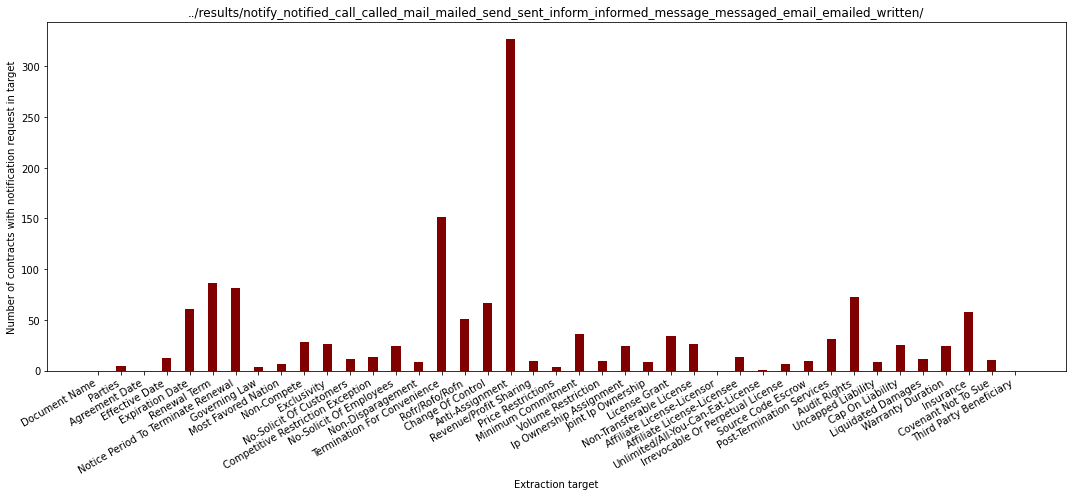

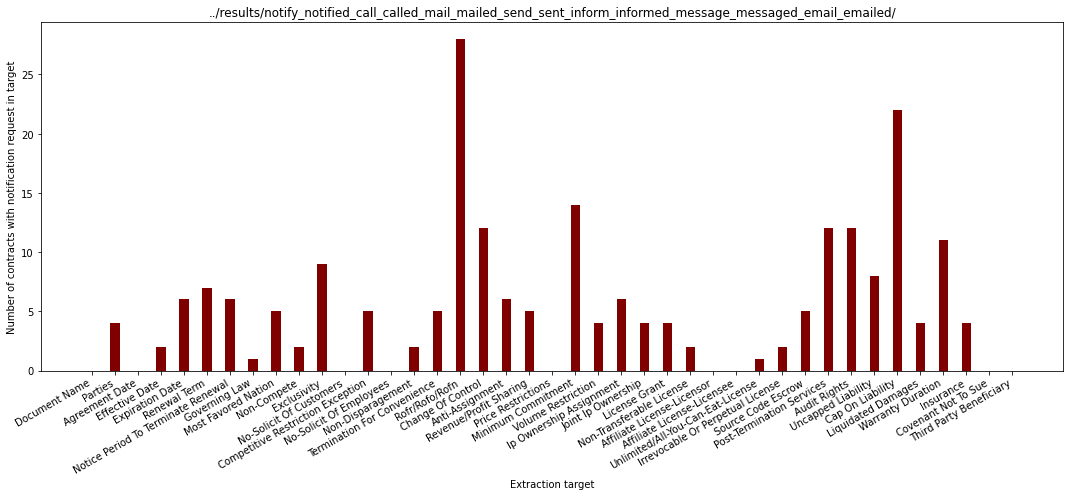

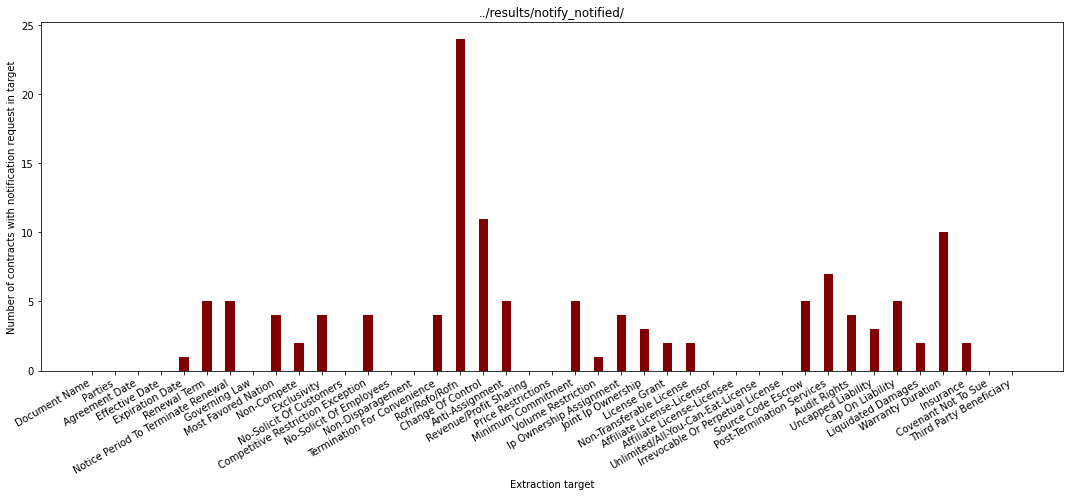

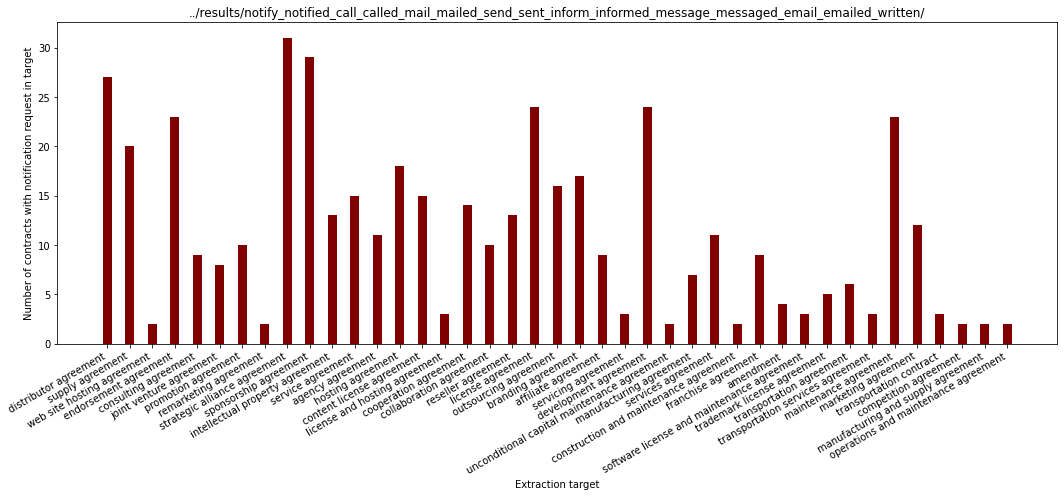

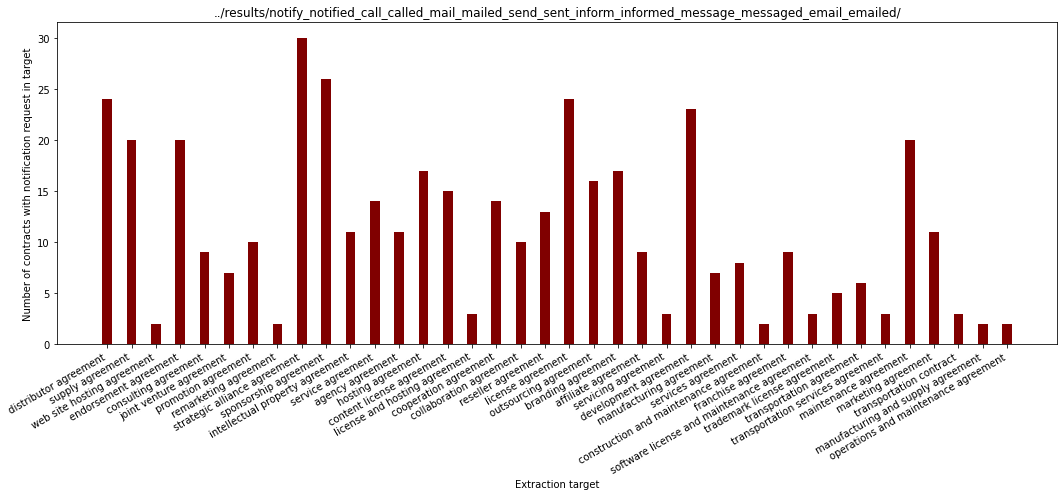

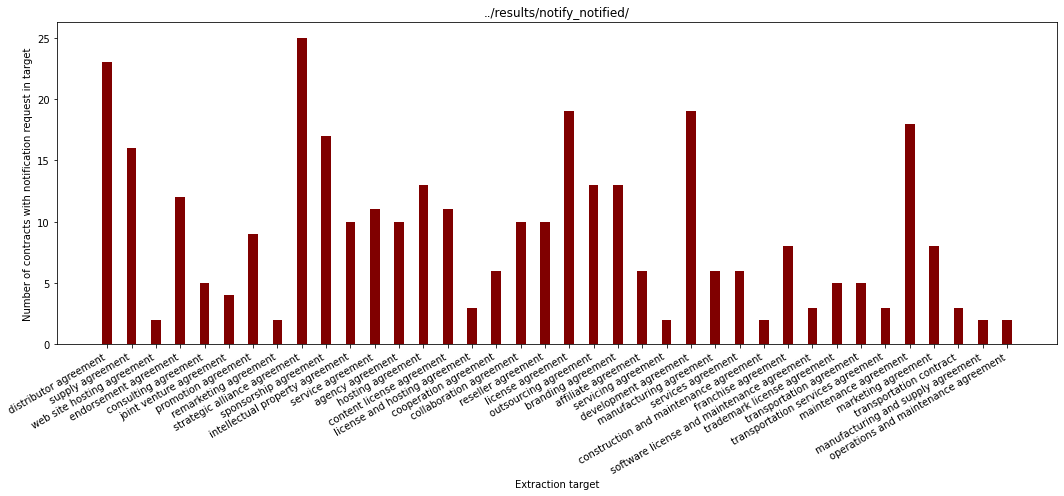

In [44]:
search_strings = [
    " notify | notified | call | called | mail | mailed | send | sent | inform | informed | message | messaged | email | emailed | written ",
    " notify | notified | call | called | mail | mailed | send | sent | inform | informed | message | messaged | email | emailed ",
    " notify | notified"
]

for search_string in search_strings:
    path = '../results/' + search_string.replace(" ", "") \
                                        .replace("|", "_") + '/'

    stats = {}
    for target in extraction_targets:
        tmp_df = df.explode(target)[['title', 'type', target]]
        tmp_df = tmp_df.fillna('')
        tmp_df = tmp_df[tmp_df[target].str.contains(search_string, case=False)]

        os.makedirs(os.path.dirname(path), exist_ok=True)
        tmp_df.to_csv(path + target.replace("/", "_") + '.csv')

        tmp_df = tmp_df.drop_duplicates(['title'])
        stats[target] = len(tmp_df)
        # print(target, len(tmp_df))

    plot(stats, extraction_targets, path, 'distribution-by-clause-type.png')


# search in entire content
agreement_types = df.type.unique()
agreement_types = [item for item in agreement_types if not(pd.isnull(item)) == True]
agreement_types = [item for item in agreement_types if item]
# print(len(agreement_types))
# print(agreement_types)

for search_string in search_strings:
    path = '../results/' + search_string.replace(" ", "") \
                                        .replace("|", "_") + '/'

    stats = {}
    for agreement_type in agreement_types:
        # print(agreement_type)
        tmp_df = df[['title', 'type', 'context']]
        tmp_df = tmp_df.fillna('')

        tmp_df = tmp_df[tmp_df['type'].str.contains(agreement_type, case=False)]
        tmp_df = tmp_df[tmp_df['context'].str.contains(search_string, case=False)]

        os.makedirs(os.path.dirname(path), exist_ok=True)
        tmp_df = tmp_df.drop_duplicates(['title'])
        

        count = len(tmp_df)
        if(count > 1):
            stats[agreement_type] = count    

    plot(stats, stats.keys(), path, 'distribution-by-agreement-type.png')


In [45]:
# #Service agreements only
# filter_service_agreements = [
#     'consulting agreement',
#     'service agreement',
#     'outsourcing agreement',
#     'servicing agreement',
#     'development agreement',
#     'transportation agreement',
#     'transportation service agreement',
#     'maintenance agreement',
#     'operations and maintenance agreement',
#     'construction and maintenance agreement'
# ]

# df = df[df['type'].isin(filter_service_agreements)]

### Extract annotation in supply chain contracts

In [46]:
## Need to run previous blocks to get df
## drop NA from df
df.dropna(inplace=True, subset="type", how='any')
df_supply = df[df['type'].str.contains('supply')]
df_supply = df_supply[['title', 'context', 'type']]
df_supply      # 'title' - contract file name; 'context' - contract content;

,title,context,type
2,LohaCompanyltd_20191209_F-1_EX-10.16_11917878_...,Exhibit 10.16 SUPPLY CONTRACT Contract No: Dat...,supply agreement
16,ReynoldsConsumerProductsInc_20191115_S-1_EX-10...,Exhibit 10.18\n\nMASTER SUPPLY AGREEMENT\n\nMA...,supply agreement
54,VERICELCORP_08_06_2019-EX-10.10-SUPPLY AGREEMENT,Exhibit 10.10\n\nCERTAIN CONFIDENTIAL PORTIONS...,supply agreement
70,MEDIWOUNDLTD_01_15_2014-EX-10.6-SUPPLY AGREEMENT,Exhibit 10.6 MediWound Ltd. and Challeng...,supply agreement
71,UpjohnInc_20200121_10-12G_EX-2.6_11948692_EX-2...,Exhibit 2.6\n\nFINAL VERSION\n\nFORM OF\n\nMAN...,supply agreement
107,"BELLRINGBRANDS,INC_02_07_2020-EX-10.18-MASTER ...",EXHIBIT 10.18\n\nCERTAIN CONFIDENTIAL INFORMAT...,master supply agreement
115,"BELLICUMPHARMACEUTICALS,INC_05_07_2019-EX-10.1...",Exhibit 10.1 [***] = Certain confidential info...,supply agreement
169,"GRIDIRONBIONUTRIENTS,INC_02_05_2020-EX-10.3-SU...",EXHIBIT 10.3 SUPPLY AGREEMENT This Agreement (...,supply agreement
188,"INTERSECTENT,INC_05_11_2020-EX-10.1-SUPPLY AGR...",Exhibit 10.1 [*] Certain confidential informat...,supply agreement
194,"VAPOTHERM, INC. - Manufacturing and Supply Agr...",Exhibit 10.14\n\n[* * *] = Certain confidentia...,manufacturing and supply agreement


## On processed data

### Average # of words in a condition
reference: https://pandas.pydata.org/docs/reference/api/pandas.json_normalize.html

In [47]:
"""with open('./processed.json', 'r') as f:
    processed = json.load(f)


df_proc = pd.json_normalize(processed, "token")[["type", "text"]]
# df_proc = df_proc.applymap(str)
for col in df_proc.columns:
    df_proc[col] = df_proc[col].astype('string')
print('columns:', df_proc.columns)
# print(df_proc)
print(df_proc["type"].dtype)
df_condition = df_proc[df_proc['type'].str.contains("condition")]
df_condition['#words'] = df_condition['text'].str.count(' ') + 1
print(df_condition)
avg_num_word = sum(df_condition['#words'].to_list()) / df_condition['#words'].shape[0]
print('Average # of words in a condition:', round(avg_num_word))"""

'with open(\'./processed.json\', \'r\') as f:\n    processed = json.load(f)\n\n\ndf_proc = pd.json_normalize(processed, "token")[["type", "text"]]\n# df_proc = df_proc.applymap(str)\nfor col in df_proc.columns:\n    df_proc[col] = df_proc[col].astype(\'string\')\nprint(\'columns:\', df_proc.columns)\n# print(df_proc)\nprint(df_proc["type"].dtype)\ndf_condition = df_proc[df_proc[\'type\'].str.contains("condition")]\ndf_condition[\'#words\'] = df_condition[\'text\'].str.count(\' \') + 1\nprint(df_condition)\navg_num_word = sum(df_condition[\'#words\'].to_list()) / df_condition[\'#words\'].shape[0]\nprint(\'Average # of words in a condition:\', round(avg_num_word))'

### Extract text with types

In [48]:
"""## Need to run previous block for 'processed'
# "Condition triggering an action"
df_relation = pd.json_normalize(processed, "relations")[["type", "source"]]
df_relation.dropna(inplace=True, subset="type", how='any')
df_relation = df_relation[df_relation["type"].str.contains("Condition triggering an action")]
df_token = pd.json_normalize(processed, "token")
for col in df_relation.columns:
    df_relation[col] = df_relation[col].astype('string')
for col in df_token.columns:
    df_token[col] = df_token[col].astype('string')
# print(df_relation)
# print(df_token)
df_join_triggering_condition = pd.merge(df_relation, df_token, left_on = 'source', right_on = 'id', suffixes=('_relation', '_token'), copy=False)
print(df_join_triggering_condition)"""

'## Need to run previous block for \'processed\'\n# "Condition triggering an action"\ndf_relation = pd.json_normalize(processed, "relations")[["type", "source"]]\ndf_relation.dropna(inplace=True, subset="type", how=\'any\')\ndf_relation = df_relation[df_relation["type"].str.contains("Condition triggering an action")]\ndf_token = pd.json_normalize(processed, "token")\nfor col in df_relation.columns:\n    df_relation[col] = df_relation[col].astype(\'string\')\nfor col in df_token.columns:\n    df_token[col] = df_token[col].astype(\'string\')\n# print(df_relation)\n# print(df_token)\ndf_join_triggering_condition = pd.merge(df_relation, df_token, left_on = \'source\', right_on = \'id\', suffixes=(\'_relation\', \'_token\'), copy=False)\nprint(df_join_triggering_condition)'

In [49]:
# df_join_triggering_condition.to_csv('triggering_condition.csv')

### Extract all text and their condition phrases

In [50]:
with open('./processed.json', 'r') as f:
    processed = json.load(f)

In [51]:
## Need to run previous block for 'processed'
df_text = pd.json_normalize(processed, "token", "text", record_prefix = 'token.', meta_prefix = '')
# df_text.drop(columns="token.id", inplace=True)
df_text = df_text[df_text['token.type'].str.contains('condition_phrase')]
# df_text.dropna(inplace=True, subset="token", how='any')
df_text

,token.id,token.type,token.text,text
2,token-cl34l9n0t00b5296a94qjhsxa,time_sensitive_condition_phrase,not later than ten Business Days after demand ...,All amounts due under this Section 11.04 shal...
12,token-cl4m204la000b356f9iya99hx,time_sensitive_condition_phrase,"(i) if vesting occurs pursuant to Section 3(c),",Subject to the “ Six-Month Delay Toggle ” (as ...
13,token-cl4m218g00023356f6njqt3pq,time_sensitive_condition_phrase,the 15 th day of the third calendar month fol...,Subject to the “ Six-Month Delay Toggle ” (as ...
14,token-cl4m22oim0035356fb8e5s0tf,time_sensitive_condition_phrase,"otherwise, 75 days following the End Date.",Subject to the “ Six-Month Delay Toggle ” (as ...
17,token-cl3eq9q4g00f3296akwm8f8ji,modifying_condition_phrase,Subject to the “ Six-Month Delay Toggle ” (as ...,Subject to the “ Six-Month Delay Toggle ” (as ...
...,...,...,...,...
13017,token-cl4jur1gu00la356fko5p9an1,time_sensitive_condition_phrase,eighteen (18) months after his termination of ...,If within the period ending one year after a C...
13021,token-cl4jupbgo00kj356fr3amz4wx,modifying_condition_phrase,"Following termination of employment,",If within the period ending one year after a C...
13022,token-cl4juripy00ma356frgbqo60v,modifying_condition_phrase,"Notwithstanding the foregoing,",If within the period ending one year after a C...
13027,token-cl4juzrob0008356f680avjnd,triggering_condition_phrase,on the earlier of (i) the expiration of the Fo...,This Letter Agreement shall terminate on the e...


In [52]:
# %pip install nltk
# %pip install gensim
import nltk
# nltk.download('popular')  # reference: https://www.nltk.org/install.html
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
import numpy as np
import re
goog_wordvecs = gensim.models.KeyedVectors.load_word2vec_format('../GoogleNews-vectors-negative300.bin', binary=True, limit=100000)     # download from https://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/

average length of condition phrase: 21
median: 13.0 1st & 3rd quartiles: 7.0 24.0


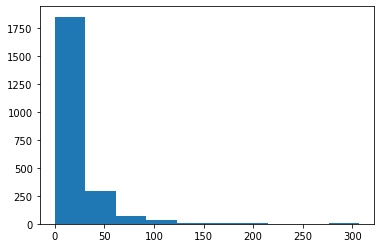

In [53]:
len_condition = []
for row in range(df_text.shape[0]):
    condition = df_text.iloc[row,-2]

    ## Split words around '/'
    condition = condition.replace('/', ' ')

    ## Convert all words to lower case
    condition = condition.lower()

    ## Remove punctuations
    condition = re.sub(r'[^\w\d\s]', ' ', condition)

    ## Convert out of dict words to '<unk>' token 
    tokenize_condition = word_tokenize(condition)

    ## Len
    len_condition.append(len(tokenize_condition))

## Average len
avg_len = sum(len_condition) / df_text.shape[0]
print('average length of condition phrase:', round(avg_len))
plt.hist(len_condition)
len_condition = np.array(len_condition)
print('median:', np.median(len_condition), '1st & 3rd quartiles:', np.percentile(len_condition, 25), np.percentile(len_condition, 75))

### Construct embeddings

In [54]:
"""
X = []
y = []
# for row in range(df_text.shape[0]):
for row in range(1):
    try:
        text = df_text.iloc[row,-1]
        condition = df_text.iloc[row,-2]
        id = df_text.iloc[row,0]

        ## Split words around '/'
        text = text.replace('/', ' ')
        condition = condition.replace('/', ' ')

        ## Convert all words to lower case
        text = text.lower()
        condition = condition.lower()

        ## Remove punctuations
        text = re.sub(r'[^\w\d\s]', ' ', text)
        condition = re.sub(r'[^\w\d\s]', ' ', condition)

        ## Convert out of dict words to '<unk>' token 
        tokenize = word_tokenize(text)
        tokenize_condition = word_tokenize(condition)
        tokenized = [x if x in goog_wordvecs.key_to_index.keys() else '<unk>' for x in tokenize]
        tokenized_condition = [x if x in goog_wordvecs.key_to_index.keys() else '<unk>' for x in tokenize_condition]
        text_proc = " ".join(tokenized)
        condition_proc = " ".join(tokenized_condition)

        ## Add average vector to google Word2Vec dict to represent words out of dict 
        if not '<unk>' in list(goog_wordvecs.key_to_index.keys()):
            mean_vec = goog_wordvecs.get_mean_vector(tokenize, ignore_missing=True)   # represent unknown token
            goog_wordvecs.add_vector('<unk>', mean_vec)

        idx_start_char = text_proc.index(condition_proc)
        idx_start_word = len(text_proc[:idx_start_char].split())
        idx_end_word = idx_start_word + len(tokenized_condition)

        wv = goog_wordvecs[tokenized]

        window_size = 8
        tol = 2     # condition window with max how many words not in condition phrase

        window_vec = [np.append(np.sum(wv[i:i+window_size,:], axis=0), np.cov(wv[i:i+window_size,:])[0,-1]) for i in range(len(tokenized)-window_size+1)]
        # print('# of text window:', len(window_vec))
        num_condition_window = len(tokenized_condition) - window_size + 1 + tol*2
        # print('# of condition window:', num_condition_window)

        ## Create labels for each text window (1 - condition, 0 - outside of condition)
        window_label = np.repeat(0, len(window_vec))
        window_label[max(idx_start_word-tol, 0):min(idx_end_word+tol, len(window_vec))] = 1     # ensure idx not out of bound

        X.extend(window_vec)
        y.extend(window_label)

    except Exception as e:
        print(f'------- id: {id} -------')
        print('Error message:', e)
        print('text:', text, ';\ncondition:', condition)
        print('text tokens:', tokenized, ';\ncondition tokens:', tokenized_condition)
        print('processed text:', text_proc, ';\nprocessed condition:', condition_proc)
        print('starting idx:', idx_start_word, '; ending idx:', idx_end_word)
        print('window_label:', window_label)
        continue

# print('y:', y)
print('len of X:', len(X))
print('len of y:', len(y))
X = np.array(X)
y = np.array(y)
"""

'\nX = []\ny = []\n# for row in range(df_text.shape[0]):\nfor row in range(1):\n    try:\n        text = df_text.iloc[row,-1]\n        condition = df_text.iloc[row,-2]\n        id = df_text.iloc[row,0]\n\n        ## Split words around \'/\'\n        text = text.replace(\'/\', \' \')\n        condition = condition.replace(\'/\', \' \')\n\n        ## Convert all words to lower case\n        text = text.lower()\n        condition = condition.lower()\n\n        ## Remove punctuations\n        text = re.sub(r\'[^\\w\\d\\s]\', \' \', text)\n        condition = re.sub(r\'[^\\w\\d\\s]\', \' \', condition)\n\n        ## Convert out of dict words to \'<unk>\' token \n        tokenize = word_tokenize(text)\n        tokenize_condition = word_tokenize(condition)\n        tokenized = [x if x in goog_wordvecs.key_to_index.keys() else \'<unk>\' for x in tokenize]\n        tokenized_condition = [x if x in goog_wordvecs.key_to_index.keys() else \'<unk>\' for x in tokenize_condition]\n        text_proc =

### Construct embeddings from Sentence Transformer

In [55]:
# %pip install sentence-transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

X = []
y = []
for row in range(df_text.shape[0]):
# for row in range(1):
    try:
        text = df_text.iloc[row,-1]
        condition = df_text.iloc[row,-2]
        id = df_text.iloc[row,0]

        ## Split words around '/'
        text = text.replace('/', ' ')
        condition = condition.replace('/', ' ')

        ## Convert all words to lower case
        text = text.lower()
        condition = condition.lower()

        ## Remove punctuations
        text = re.sub(r'[^\w\d\s]', ' ', text)
        condition = re.sub(r'[^\w\d\s]', ' ', condition)

        ## Tokenize and rejoin, remove misaligned whitespace
        tokenized = word_tokenize(text)
        tokenized_condition = word_tokenize(condition)
        text = " ".join(tokenized)
        condition = " ".join(tokenized_condition)

        window_size = 6
        tol = 1     # condition window with max how many words not in condition phrase

        idx_start_char = text.index(condition)
        idx_end_char = idx_start_char + len(condition)  ## extract substring till [:idx_end_char]
        idx_start_word = len(text[:idx_start_char].split()) 
        idx_end_word = idx_start_word + len(tokenized_condition)## extract substring till [:idx_end_word]
        
#         print('text:',text)
#         print('condition:', condition)
#         print('idx_start_word:', idx_start_word)
#         print('idx_end_word:', idx_end_word)
        
        if not window_size:
            if idx_start_char > 0:
                window_text = text[:idx_start_char]
                window_embed = model.encode(window_text)
                X.extend(window_embed)
                y.append(0)
            window_text = text[idx_start_char:idx_end_char]
            window_embed = model.encode(window_text)
            X.extend(window_embed)
            y.append(1)
            if idx_end_char < len(text):
                window_text = text[idx_end_char:]
                window_embed = model.encode(window_text)
                X.extend(window_embed)
                y.append(0)
        else:
            window_text = [" ".join(tokenized[i:i+window_size]) for i in range(len(tokenized)-window_size+1)]
            window_embed = model.encode(window_text)
            num_condition_window = len(tokenized_condition) - window_size + 1 + tol*2
            ## Create labels for each text window (1 - condition, 0 - outside of condition)
            window_label = np.repeat(0, len(window_text))
            window_label[max(idx_start_word-tol, 0):min(idx_end_word+tol, len(window_text))] = 1     # ensure idx not out of bound

            X.extend(window_embed)
            y.extend(window_label)

    except Exception as e:
        print(f'------- id: {id} -------')
        print('Error message:', e)
        print('text:', text, ';\ncondition:', condition)
        print('text tokens:', tokenized, ';\ncondition tokens:', tokenized_condition)
        print('processed text:', text_proc, ';\nprocessed condition:', condition_proc)
        print('starting idx:', idx_start_word, '; ending idx:', idx_end_word)
        print('window_label:', window_label)
        continue


    
X = np.array(X)
y = np.array(y)
print('labels:', y)

print('shape of X_sen:', X.shape)
print('shape of y_sen:', y.shape)

labels: [0 0 0 ... 1 1 1]
shape of X_sen: (338516, 384)
shape of y_sen: (338516,)


### Construct documents

In [75]:
X_doc = []
y_doc = []
for row in range(df_text.shape[0]):
# for row in range(1):
    try:
        text = df_text.iloc[row,-1]
        condition = df_text.iloc[row,-2]
        id = df_text.iloc[row,0]

        ## Split words around '/'
        text = text.replace('/', ' ')
        condition = condition.replace('/', ' ')

        ## Convert all words to lower case
        text = text.lower()
        condition = condition.lower()

        ## Remove punctuations
        text = re.sub(r'[^\w\d\s]', ' ', text)
        condition = re.sub(r'[^\w\d\s]', ' ', condition)

        ## Tokenize and rejoin, remove misaligned whitespace
        tokenized = word_tokenize(text)
        tokenized_condition = word_tokenize(condition)
        text = " ".join(tokenized)
        condition = " ".join(tokenized_condition)

        window_size = None
        tol = 1     # condition window with max how many words not in condition phrase

        idx_start_char = text.index(condition)
        idx_end_char = idx_start_char + len(condition)  ## extract substring till [:idx_end_char]
        idx_start_word = len(text[:idx_start_char].split()) 
        idx_end_word = idx_start_word + len(tokenized_condition)## extract substring till [:idx_end_word]

        if not window_size:
            if idx_start_char > 0:
                X_doc.append(text[:idx_start_char])
                y_doc.append(0)
            X_doc.append(text[idx_start_char:idx_end_char])
            y_doc.append(1)
            if idx_end_char < len(text):
                X_doc.append(text[idx_end_char:])
                y_doc.append(0)
        else:
            window_text = [" ".join(tokenized[i:i+window_size]) for i in range(len(tokenized)-window_size+1)]
            num_condition_window = len(tokenized_condition) - window_size + 1 + tol*2

            ## Create labels for each text window (1 - condition, 0 - outside of condition)
            window_label = np.repeat(0, len(window_text))
            window_label[max(idx_start_word-tol, 0):min(idx_end_word+tol, len(window_text))] = 1     # ensure idx not out of bound

            X_doc.extend(window_text)
            y_doc.extend(window_label)

    except Exception as e:
        print(f'------- id: {id} -------')
        print('Error message:', e)
        print(' - text:', text, ';\n - condition:', condition)
        

print('len of X_doc:', len(X_doc))
print('len of y_doc:', len(y_doc))
y_doc = np.array(y_doc)

len of X_doc: 5982
len of y_doc: 5982


### Dimension reduction

In [57]:
# %pip install -U scikit-learn==0.22
from sklearn.decomposition import PCA
n_pc_trial = None
if n_pc_trial:
    pca = PCA(n_components=n_pc_trial)
    pca.fit(X)
    print('sum of variance explained:',sum(pca.explained_variance_ratio_))
    import matplotlib.pyplot as plt
    plt.plot(pca.explained_variance_ratio_)

In [58]:
n_pc = None
if not n_pc:
    X_pc = X
    print('no PCA performed!')
elif n_pc != n_pc_trial:
    pca = PCA(n_components=n_pc)
    X_pc = pca.fit_transform(X)
else:
    X_pc = pca.transform(X)
print('X shape:', X_pc.shape, 'y shape:', y.shape)

no PCA performed!
X shape: (338516, 384) y shape: (338516,)


### Shuffle

In [59]:
## Shuffle and split dataset
from sklearn.model_selection import StratifiedShuffleSplit
train_idx, val_test_idx = next(StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=233).split(X_pc, y))
X_train, y_train = X_pc[train_idx], y[train_idx]
X_val_test, y_val_test = X_pc[val_test_idx], y[val_test_idx]

val_idx, test_idx = next(StratifiedShuffleSplit(n_splits=1, test_size=0.33333, random_state=233).split(X_val_test, y_val_test))
X_val, y_val = X_val_test[val_idx], y_val_test[val_idx]
X_test, y_test = X_val_test[test_idx], y_val_test[test_idx]

X_train.shape

(236961, 384)

### Resample

In [60]:
## percentage of condition class
ratio_class = np.mean(y_train==1)
print('ratio of condition class:', ratio_class)

ratio of condition class: 0.1457877034617511


In [61]:
## Resample to balance classes
from sklearn.utils import resample
reference_label = 0
n_sample = sum(y_train == reference_label) // 2
X_resampled, y_resampled = resample(X_train[y_train == (1-reference_label)],
                                        y_train[y_train == (1-reference_label)],
                                        replace=True,
                                        n_samples=n_sample,
                                        random_state=233)
X_balanced = np.vstack((X_train[y_train == reference_label], X_resampled))
y_balanced = np.hstack((y_train[y_train == reference_label], y_resampled))
from sklearn.utils import shuffle
X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=233)
print('X_train shape:', X_balanced.shape, 'y_train shape:', y_balanced.shape)
ratio_class = np.sum(y_balanced==1) / y_balanced.shape[0]
print('ratio of condition class:', ratio_class)

X_train shape: (303622, 384) y_train shape: (303622,)
ratio of condition class: 0.3333322354770076


In [62]:
X_train = X_balanced
y_train = y_balanced

### Modeling

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# %pip install mlxtend
from mlxtend.plotting import plot_confusion_matrix
## Reverse the prediction of text windows with neighbors of high-confident condition
def reverse_pred(preds, pred_probs, y_val, n_nb=2, bce_thres=0.1): # n_nb # num of neighbors to look at 
    probs_smooth = pred_probs + 0.001
    bce = -probs_smooth[:, 0]*np.log(probs_smooth[:, 0])-probs_smooth[:, 1]*np.log(probs_smooth[:, 1])
    bce_min = min(bce)
    bce_max = max(bce)
#     print('range of Binary Cross Entropy:', round(bce_min,3), '~', round(bce_max,3))
#     print('sample prob of correct predictions:\n', probs_smooth[preds==y_val])
    import seaborn as sns
    # Plot the distribution of binary cross entropy
    sns.displot(bce[preds==0])
    plt.show()

    idx = np.array([], dtype = int)
    for i, ce in enumerate(bce[:-n_nb]):
        flag_fore = False
        flag_after = False
        if preds[i] == 0:
            if sum(preds[i-n_nb:i] == 1) > 0 and sum(bce[i-n_nb:i] < bce_thres) > 0:
    #         if sum(preds[i-n_nb:i] == 1) > 0:
                flag_fore = True
            if sum(preds[i+1:i+n_nb+1] == 1) > 0 and sum(bce[i+1:i+n_nb+1] < bce_thres) > 0:
    #         if sum(preds[i+1:i+n_nb+1] == 1) > 0:
                flag_after = True
            if (flag_fore and flag_after):
                idx = np.append(idx, i)
    print('number of reversed non-condition predictions:', idx.shape[0])
    preds_rev = np.copy(preds)
    preds_rev[idx] = 1
    
    ## Plot confusion matrix
    conf_matrix = confusion_matrix(y_true=y_val, y_pred=preds_rev)
#     fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(4, 4), cmap=plt.cm.viridis)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot()
    plt.xlabel('Predictions', fontsize=15)
    plt.ylabel('Actuals', fontsize=15)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()
    
    return preds_rev

#### KNN

k = 50 raw, accuracy: 80.68%, precision: 32.47%, recall: 30.11%, f1: 31.24%


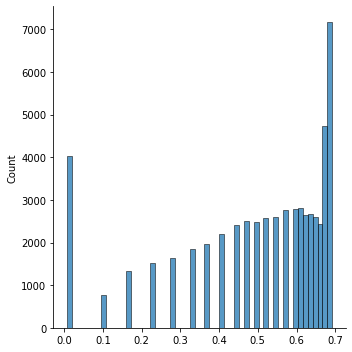

number of reversed non-condition predictions: 7


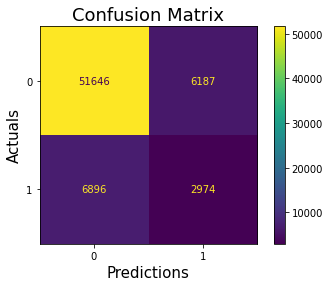

k = 50 processed, accuracy: 80.68%, precision: 32.46%, recall: 30.13%, f1: 31.25%



In [35]:
from sklearn import neighbors
## Select k
accuracies = []
probs = np.empty([y_val.shape[0], 0])
for k in range(50, 60, 20):
    knn_clf = neighbors.KNeighborsClassifier(k, weights='uniform')
    knn_clf.fit(X_train, y_train)
    preds = knn_clf.predict(X_val)
    pred_probs = knn_clf.predict_proba(X_val)
    ## Calculate accuracy
    acc = np.mean(preds == y_val[:])
    tp = (preds == 1) & (y_val[:] == 1)
    precision = sum(tp) / sum(preds == 1)
    recall = sum(tp) / sum(y_val[:] == 1)
    f1 = 2 * (precision * recall) / (precision + recall)
    print('k = {} raw, accuracy: {:.2%}, precision: {:.2%}, recall: {:.2%}, f1: {:.2%}'.format(k, acc, precision, recall, f1))
    accuracies.append(acc)
    probs = np.hstack((probs, pred_probs))
    ## Reverse predictions with neighbors of high-confident conditions
    preds_rev = reverse_pred(preds, pred_probs, y_val, n_nb=1, bce_thres=0.6)
    ## Calculate accuracy
    acc = np.mean(preds_rev == y_val[:])
    tp = (preds_rev == 1) & (y_val[:] == 1)
    precision = sum(tp) / sum(preds_rev == 1)
    recall = sum(tp) / sum(y_val[:] == 1)
    f1 = 2 * (precision * recall) / (precision + recall)
    print('k = {} processed, accuracy: {:.2%}, precision: {:.2%}, recall: {:.2%}, f1: {:.2%}\n'.format(k, acc, precision, recall, f1))

Window = 6, tol = 1, n_nb=2, thres=0.01:

range of Binary Cross Entropy: 0.006 ~ 0.693

number of reversed non-condition predictions: 1153

k = 10, accuracy: 76.62%, precision: 27.05%, recall: 35.59%, f1: 30.74%

number of reversed non-condition predictions: 123

k = 30, accuracy: 79.52%, precision: 31.15%, recall: 33.43%, f1: 32.25%

number of reversed non-condition predictions: 18

k = 50, accuracy: 80.66%, precision: 32.44%, recall: 30.14%, f1: 31.25%

number of reversed non-condition predictions: 1

k = 70, accuracy: 81.11%, precision: 32.19%, recall: 26.75%, f1: 29.22%

Window = 6, tol = 1, n_nb=2, thres=0.1:

number of reversed non-condition predictions: 17
k = 70, accuracy: 81.10%, precision: 32.18%, recall: 26.79%, f1: 29.24%
number of reversed non-condition predictions: 5
k = 90, accuracy: 81.44%, precision: 32.08%, recall: 24.46%, f1: 27.76%
number of reversed non-condition predictions: 4
k = 110, accuracy: 81.80%, precision: 32.19%, recall: 22.47%, f1: 26.47%

Window = 6, tol = 1, n_nb=3, thres=0.4:

number of reversed non-condition predictions: 636
k = 70, accuracy: 80.44%, precision: 30.90%, recall: 27.66%, f1: 29.19%
number of reversed non-condition predictions: 404
k = 90, accuracy: 80.99%, precision: 31.09%, recall: 24.95%, f1: 27.69%
number of reversed non-condition predictions: 278
k = 110, accuracy: 81.49%, precision: 31.43%, recall: 22.82%, f1: 26.44%

k = 70 raw, accuracy: 81.11%, precision: 32.20%, recall: 26.75%, f1: 29.22%
number of reversed non-condition predictions: 636
k = 70 processed, accuracy: 80.44%, precision: 30.90%, recall: 27.66%, f1: 29.19%
k = 90 raw, accuracy: 81.44%, precision: 32.09%, recall: 24.45%, f1: 27.75%
number of reversed non-condition predictions: 404
k = 90 processed, accuracy: 80.99%, precision: 31.09%, recall: 24.95%, f1: 27.69%
k = 110 raw, accuracy: 81.80%, precision: 32.19%, recall: 22.46%, f1: 26.46%
number of reversed non-condition predictions: 278
k = 110 processed, accuracy: 81.49%, precision: 31.43%, recall: 22.82%, f1: 26.44%

In [108]:
test_preds = reverse_pred(preds, pred_probs, n_nb=3, bce_thres=0.01)
## Calculate accuracy
acc = np.mean(test_preds == y_val[:])
tp = (test_preds == 1) & (y_val[:] == 1)
precision = sum(tp) / sum(test_preds == 1)
recall = sum(tp) / sum(y_val[:] == 1)
f1 = 2 * (precision * recall) / (precision + recall)
print('k = {}, accuracy: {:.2%}, precision: {:.2%}, recall: {:.2%}, f1: {:.2%}'.format(k, acc, precision, recall, f1))

range of Binary Cross Entropy: 0.006 ~ 0.693
sample prob of correct predictions: [[9.010e-01 1.010e-01]
 [8.010e-01 2.010e-01]
 [1.001e+00 1.000e-03]
 ...
 [8.010e-01 2.010e-01]
 [7.510e-01 2.510e-01]
 [1.001e+00 1.000e-03]]
number of reversed non-condition predictions: 1534
k = 20, accuracy: 77.20%, precision: 30.75%, recall: 36.35%, f1: 33.31%


In [26]:
# plt.plot(range(5, 30, 5), accuracies)

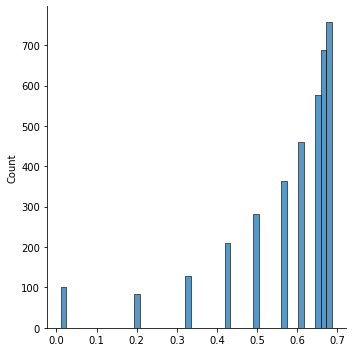

In [57]:
# %pip install seaborn
import seaborn as sns
sns.displot(bce[(preds==y_val) & (preds==1)])

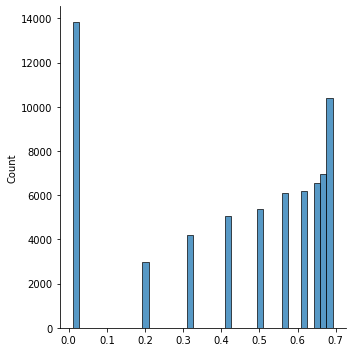

In [51]:
sns.displot(bce)

In [ ]:
## Test
k = 30
knn_clf = neighbors.KNeighborsClassifier(k, weights='uniform')
knn_clf.fit(X_train, y_train)
preds = knn_clf.predict(X_test)
pred_probs = knn_clf.predict_proba(X_test)
## Calculate accuracy
acc = np.mean(preds == y_test)
tp = (preds == 1) & (y_test == 1)
precision = sum(tp) / sum(preds == 1)
recall = sum(tp) / sum(y_test == 1)
f1 = 2 * (precision * recall) / (precision + recall)
print('test | k = {}, accuracy: {:.2%}, precision: {:.2%}, recall: {:.2%}, f1: {:.2%}'.format(k, acc, precision, recall, f1))

#### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

scores = []
gb_clfs = []
for est in range(15, 30, 10):
    for dep in range(15, 25, 5):
        for lr in [0.1, 0.3, 0.5]:
            gb_clf = GradientBoostingClassifier(n_estimators=est, learning_rate=lr, max_depth=dep, random_state=233).fit(X_train, y_train)
            gb_clfs.append(gb_clf)
    #         score = gb_clf.score(X_val, y_val)
    #         scores.append(score)
            print('# estimators = {}, max depth = {}, lr = {}'.format(est, dep, lr))
            ## Calculate accuracy
            preds = gb_clf.predict(X_val[:])
            acc = np.mean(preds == y_val[:])
            tp = (preds == 1) & (y_val[:] == 1)
            precision = sum(tp) / sum(preds == 1)
            recall = sum(tp) / sum(y_val[:] == 1)
            f1 = 2 * (precision * recall) / (precision + recall)
            print('accuracy: {:.2%}, precision: {:.2%}, recall: {:.2%}, f1: {:.2%}'.format(acc, precision, recall, f1))


# estimators = 15, max depth = 15, lr = 0.1
accuracy: 76.67%, precision: 13.08%, recall: 10.78%, f1: 11.82%
# estimators = 15, max depth = 15, lr = 0.3
accuracy: 73.64%, precision: 12.72%, recall: 13.95%, f1: 13.30%
# estimators = 15, max depth = 15, lr = 0.5
accuracy: 73.29%, precision: 12.77%, recall: 14.44%, f1: 13.56%
# estimators = 15, max depth = 20, lr = 0.1
accuracy: 74.13%, precision: 11.57%, recall: 11.80%, f1: 11.68%
# estimators = 15, max depth = 20, lr = 0.3
accuracy: 73.24%, precision: 11.64%, recall: 12.83%, f1: 12.21%
# estimators = 15, max depth = 20, lr = 0.5
accuracy: 73.22%, precision: 11.98%, recall: 13.35%, f1: 12.63%
# estimators = 25, max depth = 15, lr = 0.1
accuracy: 74.67%, precision: 12.24%, recall: 12.10%, f1: 12.17%


In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(gb_clfs[-1], X_val, y_val)

window_size = 8:

estimators = 20, max depth = 10, score: 72.44%

estimators = 20, max depth = 15, score: 75.96%

estimators = 40, max depth = 10, score: 74.44%

estimators = 40, max depth = 15, score: 75.86%

estimators = 80, max depth = 5, score: 65.21%

estimators = 80, max depth = 9, score: 75.02%

estimators = 100, max depth = 5, score: 65.97%

estimators = 100, max depth = 9, score: 75.42%

#### SVM

In [ ]:
from sklearn import svm
svm_clf = svm.SVC(kernel='linear')
svm_clf.fit(X_train[:], y_train[:])
preds = svm_clf.predict(X_val[:])
## Calculate accuracy
acc = np.mean(preds == y_val[:])
tp = (preds == 1) & (y_val[:] == 1)
precision = sum(tp) / sum(preds == 1)
recall = sum(tp) / sum(y_val[:] == 1)
f1 = 2 * (precision * recall) / (precision + recall)
print('accuracy: {:.2%}, precision: {:.2%}, recall: {:.2%}, f1: {:.2%}'.format(acc, precision, recall, f1))

# from sklearn.metrics import plot_confusion_matrix
# plot_confusion_matrix(svm_clf, X_val, y_val)

#### Naive Bayes

reference: https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.Y2m-5S-B1QJ

In [81]:
## Tokenize & Extract feature, then split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
tfidf_vectorizer=TfidfVectorizer(use_idf=True, sublinear_tf=True, stop_words=stopwords.words('english')) 
# Train doc
X_tfidf=tfidf_vectorizer.fit_transform(X_doc)
# Stratified split
from sklearn.model_selection import StratifiedShuffleSplit
train_idx, val_test_idx = next(StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=233).split(X_tfidf, y_doc))
X_train_tfidf, y_doc_train = X_tfidf[train_idx], y_doc[train_idx]
X_val_test_tfidf, y_doc_val_test = X_tfidf[val_test_idx], y_doc[val_test_idx]
print('shape of X_train_tfidf:', X_train_tfidf.shape, 'shape of X_val_test_tfidf:', X_val_test_tfidf.shape)


shape of X_train_tfidf: (4187, 3876) shape of X_val_test_tfidf: (1795, 3876)


In [82]:
## percentage of condition class
y_doc_train = np.array(y_doc_train)
ratio_class = np.sum(y_doc_train==1) / y_doc_train.shape[0]
print('ratio of condition class:', ratio_class)

ratio of condition class: 0.38046333890613804


In [83]:
# get the first vector out (for the first document) 
first_vector_tfidfvectorizer=X_train_tfidf[0] 
# place tf-idf values in a pandas data frame 
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,tfidf
effecting,0.441965
confirms,0.427178
relying,0.385494
understands,0.327152
covenant,0.293392
...,...
eight,0.000000
eighteen,0.000000
eighty,0.000000
either,0.000000


accuracy: 71.48%, precision: 71.98%, recall: 41.00%, f1: 52.24%


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


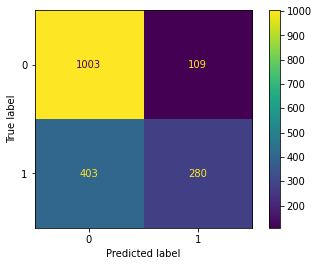

In [84]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix
num_sample = X_train_tfidf.shape[0]
train_ratio = 0.7
nb_clf = MultinomialNB(alpha=0.1).fit(X_train_tfidf, y_doc_train)
predicted = nb_clf.predict(X_val_test_tfidf)
acc = np.mean(predicted == y_doc_val_test)
tp = (predicted == 1) & (y_doc_val_test == 1)
precision = sum(tp) / sum(predicted == 1)
recall = sum(tp) / sum(y_doc_val_test == 1)
f1 = 2 * (precision * recall) / (precision + recall)
print('accuracy: {:.2%}, precision: {:.2%}, recall: {:.2%}, f1: {:.2%}'.format(acc, precision, recall, f1))
plot_confusion_matrix(nb_clf, X_val_test_tfidf, y_doc_val_test)  

### Inference on Supply contracts

In [100]:
"""MaterialsRemovalV14-Agreement-Tianchang Li-220829.pdf
## Pre-process supply contracts
# for row in range(df_supply.shape[0]):
for row in range(10):
    contract = df_supply.iloc[row,1]
"""

## Read from parsed conditions
parsed = pd.read_csv('../parsed_condition.csv', index_col=0, header=None)
parsed.reset_index(inplace=True)
parsed = parsed.iloc[:,1]
parsed.drop_duplicates(inplace=True)
parsed.dropna(inplace=True)
contracts = np.array(parsed)
print('num of sentences extracted from dependency tree:', contracts.shape[0])

"""pred_conditions = []
for row in range(10):
    contract = parsed.iloc[row]

    try:
        ## Remove new line symbol
        contract = contract.replace('\n', ' ')
        ## Split words around '/'
        contract = contract.replace('/', ' ')
        ## Convert all words to lower case
        contract = contract.lower()

        ## Remove punctuations
        contract = re.sub(r'[^\w\d\s]', ' ', contract)

        ## Tokenize and rejoin, remove misaligned whitespace
        tokenized = word_tokenize(contract)
        contract = " ".join(tokenized)

    except Exception as e:
        print(f'------- id: {id} -------')
        print('Error message:', e)
        print(' - contract:', contract)
        
    print('len of contract sentence:', len(contract))"""

## Inference class
contracts_tfidf = tfidf_vectorizer.transform(contracts)
contract_preds = nb_clf.predict(contracts_tfidf)
contract_pred_probs = nb_clf.predict_proba(contracts_tfidf)
pred_conditions = pd.DataFrame(contracts[contract_preds == 1], columns=['conditions'])

print(f'predicted condition sentences (len - {pred_conditions.shape[0]}):')
pred_conditions

num of sentences extracted from dependency tree: 950
predicted condition sentences (len - 194):


,conditions
0,after demand
1,as practicable thereafter subject to
2,after written demand
3,if aggregate amount of loss actually paid by c...
4,on or before december 31 2018
...,...
189,as provided in section 82 other than terminati...
190,that public offering not consummated closed by...
191,whether or not company then subject to such re...
192,if any such event or circumstance could reason...


In [102]:
pred_conditions.to_csv('../extraced_conditions.csv', header=True, index=False)

In [ ]:
"""    ## Extract consecutive 1's in predictions
    ## referece: https://stackoverflow.com/questions/35610834/find-consecutive-ones-in-numpy-array
    # Append zeros columns at either sides of preds
    contract_preds = np.array([contract_preds])
    append1 = np.zeros((contract_preds.shape[0],1),dtype=int)
    ext = np.column_stack((append1,contract_preds,append1))
    # Get start and stop indices with 1s as triggers
    diffs = np.diff((ext==1).astype(int),axis=1)
    starts = np.argwhere(diffs == 1)
    stops = np.argwhere(diffs == -1)
    ## Extract the corresponding words
    cond_out = []
    for i in range(len(starts)):
        window_tokenized = tokenized[starts[i, 1] - window_size:stops[i, 1] + window_size]
        window_tokenize = tokenize[starts[i, 1] - window_size:stops[i, 1] + window_size]
        cond_out.append(window_tokenized)
        # print('predicted index:', starts[i, 1] - window_size, stops[i, 1] + window_size)
        # print('predicted word interval:', window_tokenized)
        print('approximate predicted condition:', " ".join(window_tokenize))"""